В данном решении рассматривается случай классификации $RGB$ изображений размером $32 \times 32$ на заданное число классов $N\_CLASSES$

На примере с датасетом CIFAR10

# Приготовления

* ### Используемые библиотеки и константы


In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from PIL import Image
import pickle
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

USE_CUDA = True
N_CLASSES = 10
path_to_data = '../data/'
train_data_file = 'data_train.pickle'
test_data_file = 'data_test_no_labels.pickle'

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() and USE_CUDA else 'cpu')

* ### Класс для закрузки датасета из файл `pickle`

In [6]:
class MyDataset(Dataset):
    def __init__(self, input_path, is_train=True, transform=None):
        data = None
        with open(input_path,'rb') as fin:
            data = pickle.load(fin)
        
        self.X = data['data']
        self.y = data['target']
        
        self.X = [Image.fromarray(img) for img in self.X]        
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = self.X[idx]

        if self.transform: 
            sample = self.transform(sample)

        return (sample, self.y[idx])

# Загрузка данных

* ### Объявляем набор преобразований для тренировочной и тестовой 

In [31]:
# Image preprocessing modules
train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.ToTensor(),
]
)

* ### Загружаем данные батчами по $128$ Элементов

In [8]:
dataset_train = MyDataset(path_to_data + train_data_file, transform=train_transform)
dataloader_train = DataLoader(dataset_train, batch_size=128,
                        shuffle=True, num_workers=4)

dataset_test = MyDataset(path_to_data + test_data_file, transform=test_transform)
dataloader_test = DataLoader(dataset_test, batch_size=128,
                        shuffle=False, num_workers=1)

* ### Отрисовка некоторых изображений

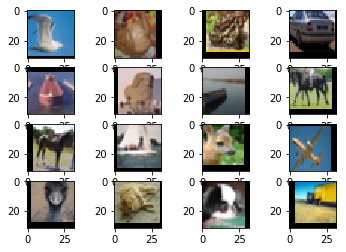

In [27]:
n=4
i=0
for X, y in dataloader_train:
    if i == n * n:
        break
    
    img = X[np.random.randint(0, X.shape[0])].numpy().transpose((1, 2, 0))
    plt.subplot(n,n,i+1)
    plt.imshow(img)
    i += 1

# Построение модели

* ### Основные слои для свёртки и переноса

In [28]:
DOWNSAMPLE_COEF = 2

def conv3x3(a_in_planes, a_out_planes, a_stride=1):
    """
    Основной строительный блок конволюций для ResNet
    Включает в себя padding=1 - чтобы размерность сохранялась после его применения
    """
    return nn.Conv2d(a_in_planes, a_out_planes,  stride=a_stride,
                     kernel_size=3, padding=1, bias=False)

def x_downsample(a_in_channels):
     return nn.Conv2d(a_in_channels, 
               a_in_channels*DOWNSAMPLE_COEF,
               kernel_size=1,
               stride=2,
               bias=False)

* ### Объявление блока остаточной сети. Количество выходных каналов зависит от `make_downsample`

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, a_in_channels, make_downsample=False, use_skip_connection=True):
        super(ResidualBlock, self).__init__()
        self.use_skip_connection = use_skip_connection
        self.make_downsample = make_downsample
        
        if self.make_downsample: coef = DOWNSAMPLE_COEF
        else: coef = 1  
        
        a_out_channels = coef * a_in_channels
        self.conv1 = conv3x3(a_in_channels, a_out_channels, a_stride=coef)
        self.bn1 = nn.BatchNorm2d(a_out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(a_out_channels, a_out_channels)
        self.bn2 = nn.BatchNorm2d(a_out_channels)
        self.downsample = x_downsample(a_in_channels)
        self.relu2 = nn.ReLU(inplace=True)
            
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.use_skip_connection: 
            if self.make_downsample:
                residual = self.downsample(x)
                
            out += residual
            
        out = self.relu2(out)
        return out

* ### Объявление самой нейронной сети

In [ ]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 16, layers[1], True)
        self.layer3 = self.make_layer(block, 32, layers[2], True)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, in_channels, blocks, make_downsample=False):
        layers = []
        layers.append(block(in_channels, make_downsample=make_downsample))
        
        out_channels = 2 * in_channels if make_downsample els in_channels
        for i in range(1, blocks):
            layers.append(block(out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
def fit_net(X, y, c_epoch, network, optimizer, batch_size=32):
    loss_fn = torch.nn.CrossEntropyLoss()
    loss_curve = []
    #  acc_curve = [] TODO

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            X_b = torch.Tensor(X[batch_idxs])
            y_b = torch.from_numpy(y[batch_idxs]).long()
            X_b = X_b.to(device)
            y_b = y_b.to(device)
            
            #Forward pass
            y_pred = network(X_b)
            loss = loss_fn(y_pred, y_b)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_acc += float(loss.item())
            
            if (b+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(iter+1, c_epoch, b+1, nbatches, loss.item()))
            
        avg_epoch_loss = loss_acc / (nbatches)
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

# Обучаем на исходных данных

In [13]:
# Hyper parameters
num_epochs = 20
num_classes = 10
batch_size = 32
learning_rate = 0.001

In [14]:
model = ConvNet(num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
fit_net(X_train, y_train, num_epochs, model, optimizer, batch_size)

Epoch [1/20], Step [100/2078], Loss: 0.2521
Epoch [1/20], Step [200/2078], Loss: 0.1366
Epoch [1/20], Step [300/2078], Loss: 0.0862
Epoch [1/20], Step [400/2078], Loss: 0.0668
Epoch [1/20], Step [500/2078], Loss: 0.1303
Epoch [1/20], Step [600/2078], Loss: 0.1129
Epoch [1/20], Step [700/2078], Loss: 0.0959
Epoch [1/20], Step [800/2078], Loss: 0.1051
Epoch [1/20], Step [900/2078], Loss: 0.0595
Epoch [1/20], Step [1000/2078], Loss: 0.1344
Epoch [1/20], Step [1100/2078], Loss: 0.0156
Epoch [1/20], Step [1200/2078], Loss: 0.1188
Epoch [1/20], Step [1300/2078], Loss: 0.0191
Epoch [1/20], Step [1400/2078], Loss: 0.0616
Epoch [1/20], Step [1500/2078], Loss: 0.0347
Epoch [1/20], Step [1600/2078], Loss: 0.0191
Epoch [1/20], Step [1700/2078], Loss: 0.0188
Epoch [1/20], Step [1800/2078], Loss: 0.0431
Epoch [1/20], Step [1900/2078], Loss: 0.1065
Epoch [1/20], Step [2000/2078], Loss: 0.0057
Epoch [2/20], Step [100/2078], Loss: 0.0946
Epoch [2/20], Step [200/2078], Loss: 0.0541
Epoch [2/20], Step [3

Epoch [10/20], Step [500/2078], Loss: 0.0032
Epoch [10/20], Step [600/2078], Loss: 0.0006
Epoch [10/20], Step [700/2078], Loss: 0.1239
Epoch [10/20], Step [800/2078], Loss: 0.0038
Epoch [10/20], Step [900/2078], Loss: 0.0111
Epoch [10/20], Step [1000/2078], Loss: 0.0019
Epoch [10/20], Step [1100/2078], Loss: 0.0005
Epoch [10/20], Step [1200/2078], Loss: 0.0023
Epoch [10/20], Step [1300/2078], Loss: 0.0018
Epoch [10/20], Step [1400/2078], Loss: 0.0083
Epoch [10/20], Step [1500/2078], Loss: 0.0003
Epoch [10/20], Step [1600/2078], Loss: 0.0002
Epoch [10/20], Step [1700/2078], Loss: 0.0027
Epoch [10/20], Step [1800/2078], Loss: 0.0051
Epoch [10/20], Step [1900/2078], Loss: 0.0530
Epoch [10/20], Step [2000/2078], Loss: 0.0001
Epoch [11/20], Step [100/2078], Loss: 0.0000
Epoch [11/20], Step [200/2078], Loss: 0.0051
Epoch [11/20], Step [300/2078], Loss: 0.0014
Epoch [11/20], Step [400/2078], Loss: 0.0007
Epoch [11/20], Step [500/2078], Loss: 0.0059
Epoch [11/20], Step [600/2078], Loss: 0.0016

Epoch [19/20], Step [500/2078], Loss: 0.0119
Epoch [19/20], Step [600/2078], Loss: 0.0000
Epoch [19/20], Step [700/2078], Loss: 0.0001
Epoch [19/20], Step [800/2078], Loss: 0.0021
Epoch [19/20], Step [900/2078], Loss: 0.0000
Epoch [19/20], Step [1000/2078], Loss: 0.0001
Epoch [19/20], Step [1100/2078], Loss: 0.0000
Epoch [19/20], Step [1200/2078], Loss: 0.0002
Epoch [19/20], Step [1300/2078], Loss: 0.0001
Epoch [19/20], Step [1400/2078], Loss: 0.0024
Epoch [19/20], Step [1500/2078], Loss: 0.0000
Epoch [19/20], Step [1600/2078], Loss: 0.0001
Epoch [19/20], Step [1700/2078], Loss: 0.0021
Epoch [19/20], Step [1800/2078], Loss: 0.0052
Epoch [19/20], Step [1900/2078], Loss: 0.0005
Epoch [19/20], Step [2000/2078], Loss: 0.0000
Epoch [20/20], Step [100/2078], Loss: 0.0000
Epoch [20/20], Step [200/2078], Loss: 0.0003
Epoch [20/20], Step [300/2078], Loss: 0.0073
Epoch [20/20], Step [400/2078], Loss: 0.0001
Epoch [20/20], Step [500/2078], Loss: 0.0008
Epoch [20/20], Step [600/2078], Loss: 0.0000

[0.11539767076475572,
 0.045762082158262496,
 0.03320464281680347,
 0.02709036276503659,
 0.02142474673243815,
 0.01830692576364138,
 0.014077780809171886,
 0.011906907437019646,
 0.010486698519959294,
 0.008328811199967551,
 0.007466839405925831,
 0.0065997386100469825,
 0.005667603608867094,
 0.004709528922008106,
 0.004748499288040181,
 0.0042463614429959886,
 0.00374638908553337,
 0.0035243655737696522,
 0.0031639911361886646,
 0.0031181450366995836]

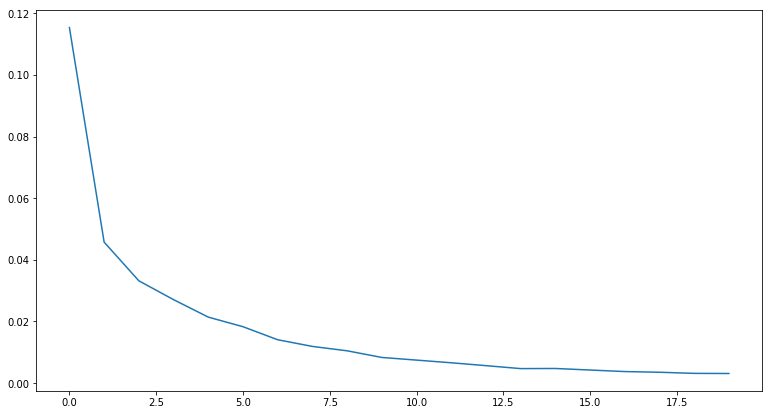

In [17]:
plt.figure(figsize=(13, 7))
plt.plot([0.11539767076475572,
 0.045762082158262496,
 0.03320464281680347,
 0.02709036276503659,
 0.02142474673243815,
 0.01830692576364138,
 0.014077780809171886,
 0.011906907437019646,
 0.010486698519959294,
 0.008328811199967551,
 0.007466839405925831,
 0.0065997386100469825,
 0.005667603608867094,
 0.004709528922008106,
 0.004748499288040181,
 0.0042463614429959886,
 0.00374638908553337,
 0.0035243655737696522,
 0.0031639911361886646,
 0.0031181450366995836])